In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cosmicodes import randfil_RM
from numpy.typing import ArrayLike
import astropy.units as u
from astropy.constants import c as speed_of_light
from rm_lite.utils import synthesis

plt.rcParams["figure.dpi"] = (
    72  # making this small for git uload - make it bigger for local viewing
)

In [2]:
rm_gaussian, rm_filament = randfil_RM.randfil_RM(nax=256)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [3]:
nx, ny = rm_gaussian.shape
x_arr_pix = np.arange(nx)
y_arr_pix = np.arange(ny)
x_arr = np.linspace(-1, 1, nx)
y_arr = np.linspace(-1, 1, ny)
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

x_grid_pix, y_grid_pix = np.meshgrid(x_arr_pix, y_arr_pix)

r_grid = np.hypot(x_grid, y_grid)

large_scale = 10 * x_grid
# large_scale = 20 * np.ones_like(x_grid)

In [4]:
small_scale = rm_gaussian
all_scale = small_scale + large_scale

In [5]:
# large_scale_pi = x_grid.copy() +1
# # large_scale_pi += large_scale_pi.min()
# large_scale_pi /= np.max(large_scale_pi) * 2
# small_scale_pi = np.abs(mRM_f) ** 0.5
# small_scale_pi /= np.max(small_scale_pi) * 2
# large_scale_pi = 0.5
# all_scale_pi = small_scale_pi + large_scale_pi
all_scale_pi = np.ones_like(x_grid)

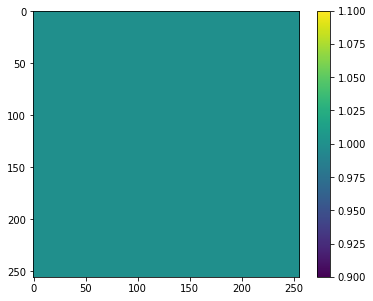

In [6]:
plt.imshow(all_scale_pi)
plt.colorbar()

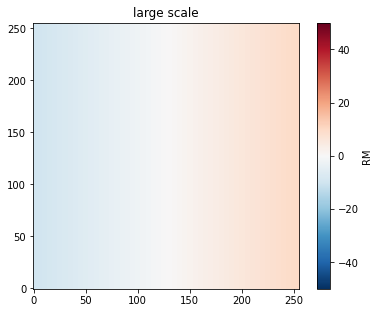

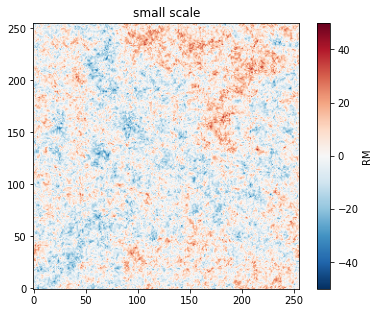

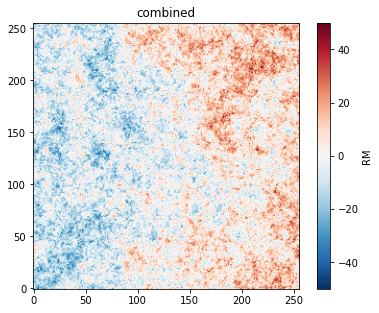

In [7]:
# fig, axs = plt.subplots(1,3)
for im_arr, title in zip(
    (large_scale, small_scale, all_scale), ("large scale", "small scale", "combined")
):
    fig, ax = plt.subplots()
    im = ax.imshow(
        im_arr, origin="lower", cmap=plt.cm.RdBu_r, vmin=-50, vmax=50, aspect="equal"
    )
    fig.colorbar(im, label="RM")
    ax.set(title=title)

In [8]:
def filter_maps(
    all_scale_arr: ArrayLike,
    cutoff: float = 0.1,
) -> tuple[ArrayLike, ArrayLike]:
    # pad

    padded = np.pad(all_scale_arr, all_scale_arr.shape, mode="reflect")

    start_x = all_scale_arr.shape[0]
    start_y = all_scale_arr.shape[1]
    len_x, len_y = all_scale_arr.shape

    all_scale_fft = np.fft.fftshift(np.fft.fft2(padded))

    nx, ny = padded.shape

    x_arr = np.linspace(-1, 1, nx)
    y_arr = np.linspace(-1, 1, ny)
    x_grid, y_grid = np.meshgrid(x_arr, y_arr)

    r_grid = np.hypot(x_grid, y_grid)

    single_dish_filter = r_grid <= cutoff
    array_filter = r_grid > cutoff

    all_scale_fft_sd = all_scale_fft.copy()
    all_scale_fft_at = all_scale_fft.copy()

    all_scale_fft_sd[~single_dish_filter] = 0 + 0j
    all_scale_fft_at[~array_filter] = 0 + 0j

    all_scale_sd = np.fft.ifft2(np.fft.ifftshift(all_scale_fft_sd))
    all_scale_at = np.fft.ifft2(all_scale_fft_at).real
    # all_scale_round_trip = np.fft.ifft2(np.fft.ifftshift(all_scale_fft))

    all_scale_sd = all_scale_sd[start_x : start_x + len_x, start_y : start_x + len_y]
    all_scale_at = all_scale_at[start_x : start_x + len_x, start_y : start_x + len_y]

    return all_scale_sd.real, all_scale_at.real

In [9]:
def rm_to_pol(
    freq: u.Quantity,
    rm_arr: ArrayLike,
    pi_arr: ArrayLike | None = None,
):
    lsq = (speed_of_light / freq).to(u.m) ** 2
    if pi_arr is None:
        pi_arr = np.ones_like(rm_arr)
    return np.exp(2j * rm_arr[..., np.newaxis] * lsq.value) * pi_arr[..., np.newaxis]

In [10]:
freq = np.arange(800, 1088, 8) * u.MHz
wave = (speed_of_light / freq).to(u.m)
lsq = wave**2
all_scale_pol = rm_to_pol(freq=freq, rm_arr=all_scale, pi_arr=all_scale_pi).T

In [11]:
chan_freq = np.arange(len(freq))

In [12]:
# cutoffs = chan_freq / len(freq) * 0.2 + 0.1
cutoffs = np.ones_like(chan_freq) * 0.05

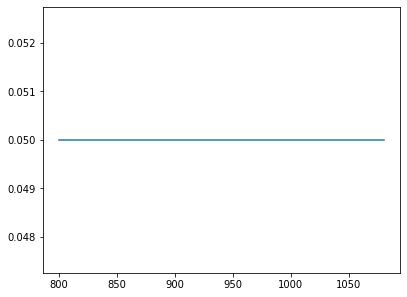

In [13]:
plt.plot(freq, cutoffs)

In [14]:
sd_pol = np.zeros_like(all_scale_pol)
at_pol = np.zeros_like(all_scale_pol)

for chan, plane in enumerate(all_scale_pol):
    cutoff = cutoffs[chan]
    sd_plane_q, at_plane_q = filter_maps(plane.real, cutoff=cutoff)
    sd_plane_u, at_plane_u = filter_maps(plane.imag, cutoff=cutoff)
    sd_pol[chan] = sd_plane_q + 1j * sd_plane_u
    at_pol[chan] = at_plane_q + 1j * at_plane_u

In [15]:
phis = synthesis.make_phi_arr(200, 1)

In [16]:
dirty_fdf_all_scale = synthesis.rmsynth_nufft(
    complex_pol_arr=all_scale_pol,
    lambda_sq_arr_m2=lsq.value,
    phi_arr_radm2=phis,
    weight_arr=np.ones_like(lsq.value),
    lam_sq_0_m2=np.mean(lsq.value),
)
dirty_fdf_sd = synthesis.rmsynth_nufft(
    complex_pol_arr=sd_pol,
    lambda_sq_arr_m2=lsq.value,
    phi_arr_radm2=phis,
    weight_arr=np.ones_like(lsq.value),
    lam_sq_0_m2=np.mean(lsq.value),
)
dirty_fdf_at = synthesis.rmsynth_nufft(
    complex_pol_arr=at_pol,
    lambda_sq_arr_m2=lsq.value,
    phi_arr_radm2=phis,
    weight_arr=np.ones_like(lsq.value),
    lam_sq_0_m2=np.mean(lsq.value),
)

INFO 2025-02-18 14:01:31.615 synthesis - rmsynth_nufft: Running RM-synthesis using the NUFFTs over 401 Faraday depth channels.
INFO 2025-02-18 14:01:34.281 synthesis - rmsynth_nufft: Running RM-synthesis using the NUFFTs over 401 Faraday depth channels.
INFO 2025-02-18 14:01:36.923 synthesis - rmsynth_nufft: Running RM-synthesis using the NUFFTs over 401 Faraday depth channels.


In [17]:
max_idx = np.argmax(np.abs(dirty_fdf_all_scale), axis=0)
max_rm_all_scale = phis[max_idx]

max_idx = np.argmax(np.abs(dirty_fdf_sd), axis=0)
max_rm_sd = phis[max_idx]


max_idx = np.argmax(np.abs(dirty_fdf_at), axis=0)
max_rm_at = phis[max_idx]

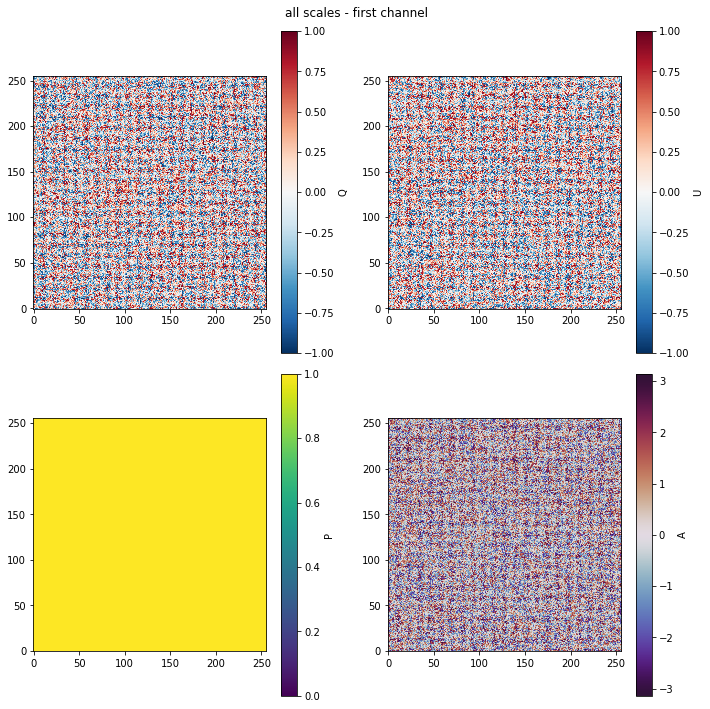

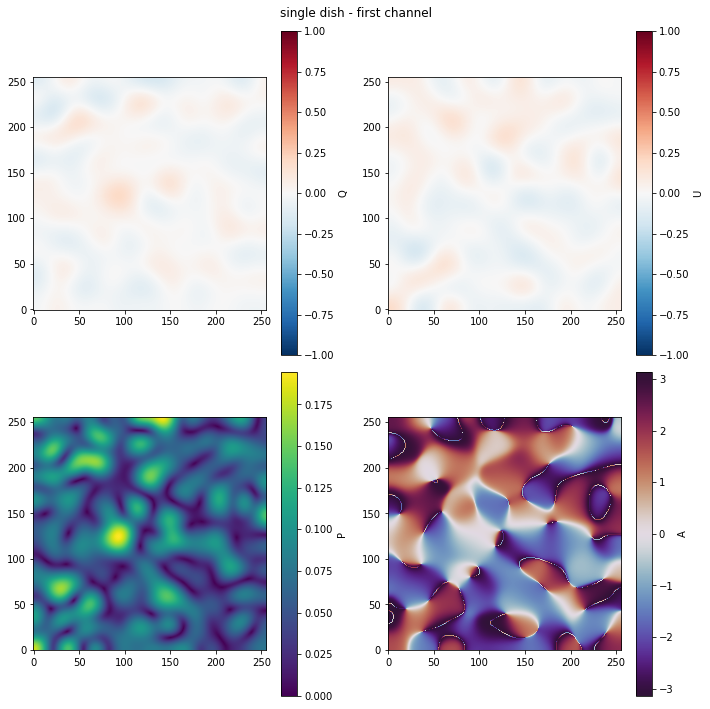

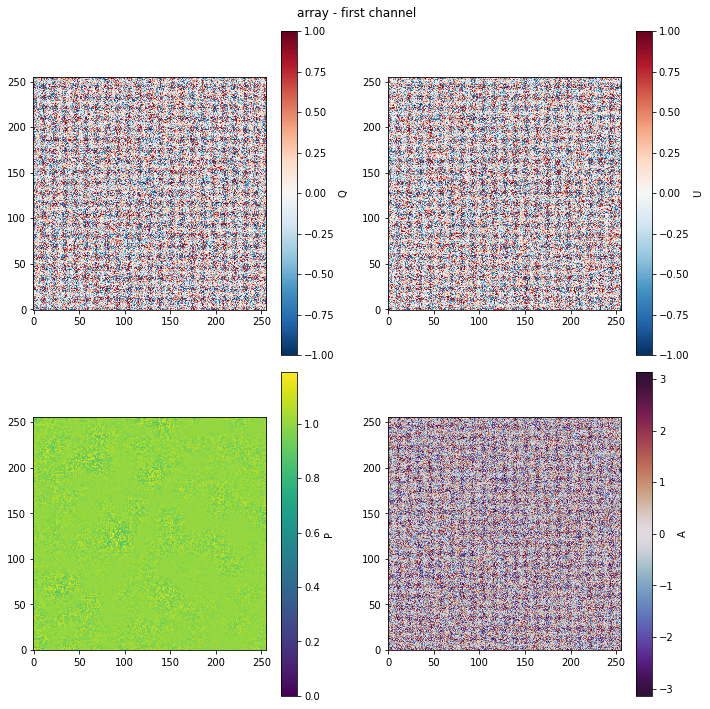

In [18]:
for pol_arr, title in zip(
    (all_scale_pol, sd_pol, at_pol),
    ("all scales", "single dish", "array"),
):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    im = axs[0].imshow(
        pol_arr[0].real, cmap=plt.cm.RdBu_r, origin="lower", vmin=-1, vmax=1
    )
    fig.colorbar(im, shrink=1, label="Q")
    im = axs[1].imshow(
        pol_arr[0].imag, cmap=plt.cm.RdBu_r, origin="lower", vmin=-1, vmax=1
    )
    fig.colorbar(im, shrink=1, label="U")
    im = axs[2].imshow(
        np.abs(pol_arr[0]),
        cmap=plt.cm.viridis,
        origin="lower",
        vmin=0,
    )
    fig.colorbar(im, shrink=1, label="P")
    im = axs[3].imshow(
        np.angle(pol_arr[0]),
        cmap=plt.cm.twilight_shifted,
        origin="lower",
        vmin=-np.pi,
        vmax=np.pi,
    )
    fig.colorbar(im, shrink=1, label="A")
    fig.suptitle(f"{title} - first channel")
    fig.tight_layout()

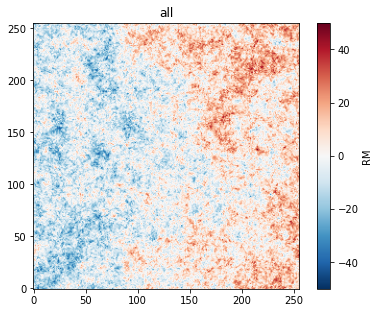

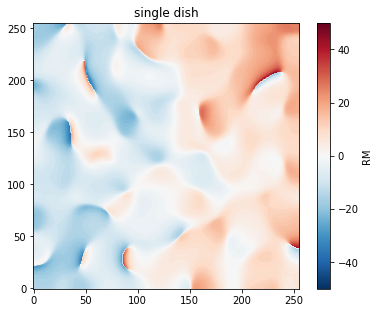

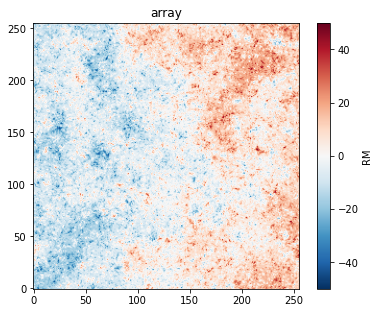

In [19]:
for rm_arr, title in zip(
    (max_rm_all_scale, max_rm_sd, max_rm_at), ("all", "single dish", "array")
):
    fig, ax = plt.subplots()
    im = ax.imshow(rm_arr.T, origin="lower", vmin=-50, vmax=50, cmap=plt.cm.RdBu_r)
    fig.colorbar(im, label="RM")
    ax.set(title=title)

[Text(0.5, 1.0, 'array')]

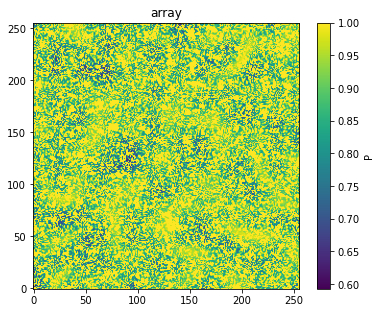

In [20]:
fig, ax = plt.subplots()
pi_arr = np.max(np.abs(dirty_fdf_at), axis=0)
im = ax.imshow(
    pi_arr,
    origin="lower",
    # vmin=0,
    vmax=1,
)
fig.colorbar(im, label="P")
ax.set(title=title)

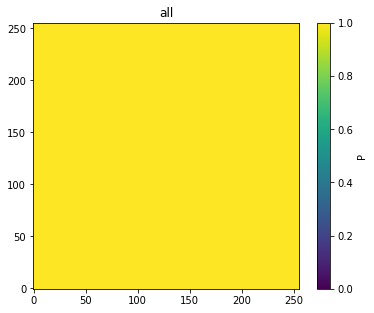

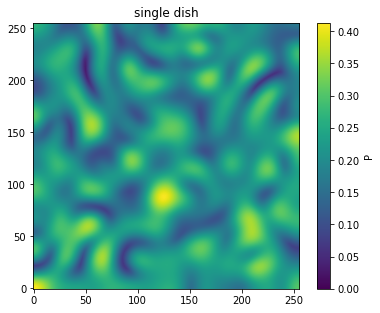

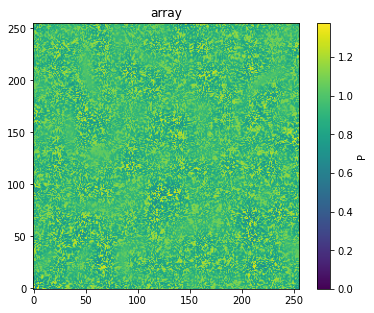

In [21]:
for fdf_arr, title in zip(
    (dirty_fdf_all_scale, dirty_fdf_sd, dirty_fdf_at), ("all", "single dish", "array")
):
    pi_arr = np.max(np.abs(fdf_arr), axis=0)
    fig, ax = plt.subplots()
    im = ax.imshow(
        pi_arr.T,
        origin="lower",
        vmin=0,
    )
    fig.colorbar(im, label="P")
    ax.set(title=title)

[Text(0.5, 1.0, 'all - array')]

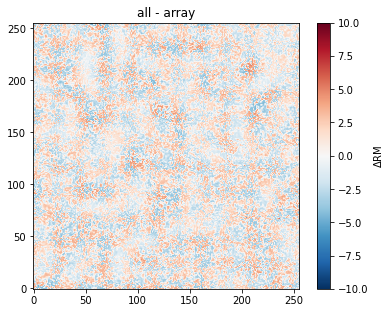

In [22]:
fig, ax = plt.subplots()
im = ax.imshow(
    (all_scale - max_rm_at.T),
    origin="lower",
    vmin=-10,
    vmax=10,
    cmap=plt.cm.RdBu_r,
)
fig.colorbar(im, label="$\Delta$RM")
ax.set(title="all - array")